In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import osyris
from numba import njit, prange, stencil
import matplotlib.colors as colors

import disctools
import disctools.disc_cuts
import disctools.datacube
import disctools.contour_integrals
import disctools.datacube_utils
import disctools.disc_analysis
import disctools.intersections
import disctools.constants
%matplotlib notebook

In [2]:
cm_to_au = 6.6845871226706E-14

In [3]:
@njit
def cut_mom_in(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom>0.005*np.max(absmom)

In [4]:
@njit(parallel=True)
def broadcast_dot(vector_array,scalar_array):
    nx,ny,nz,_=vector_array.shape
    return_array=np.zeros_like(vector_array)
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k,0]=vector_array[i,j,k,0]*scalar_array[i,j,k]
                return_array[i,j,k,1]=vector_array[i,j,k,1]*scalar_array[i,j,k]
                return_array[i,j,k,2]=vector_array[i,j,k,2]*scalar_array[i,j,k]
    return return_array

In [5]:
@njit
def get_a_on_grid_2D(star_mass,positions,velocities,dens):
    nx,ny,discard=velocities.shape
    a=np.zeros_like(dens)
    for i in prange(nx):
        for j in range(ny):
            a[i,j]=disctools.disc_analysis.get_a(star_mass,positions[i,j],velocities[i,j,:])
    return a

In [6]:
@njit
def toomre_Q(pressure,surfaceDensity):
    G=6.6743E-8
    return pressure*1.5/(np.pi*G*surfaceDensity)

@njit
def toomre_Q_array(midplanePressure,surfaceDensity):
    Q=np.zeros_like(surfaceDensity)
    nx,ny=midplanePressure.shape
    for i in prange(nx):
        for j in range(ny):
            Q[i,j]=toomre_Q(midplanePressure[i,j],surfaceDensity[i,j])
    return Q

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

<IPython.core.display.Javascript object>


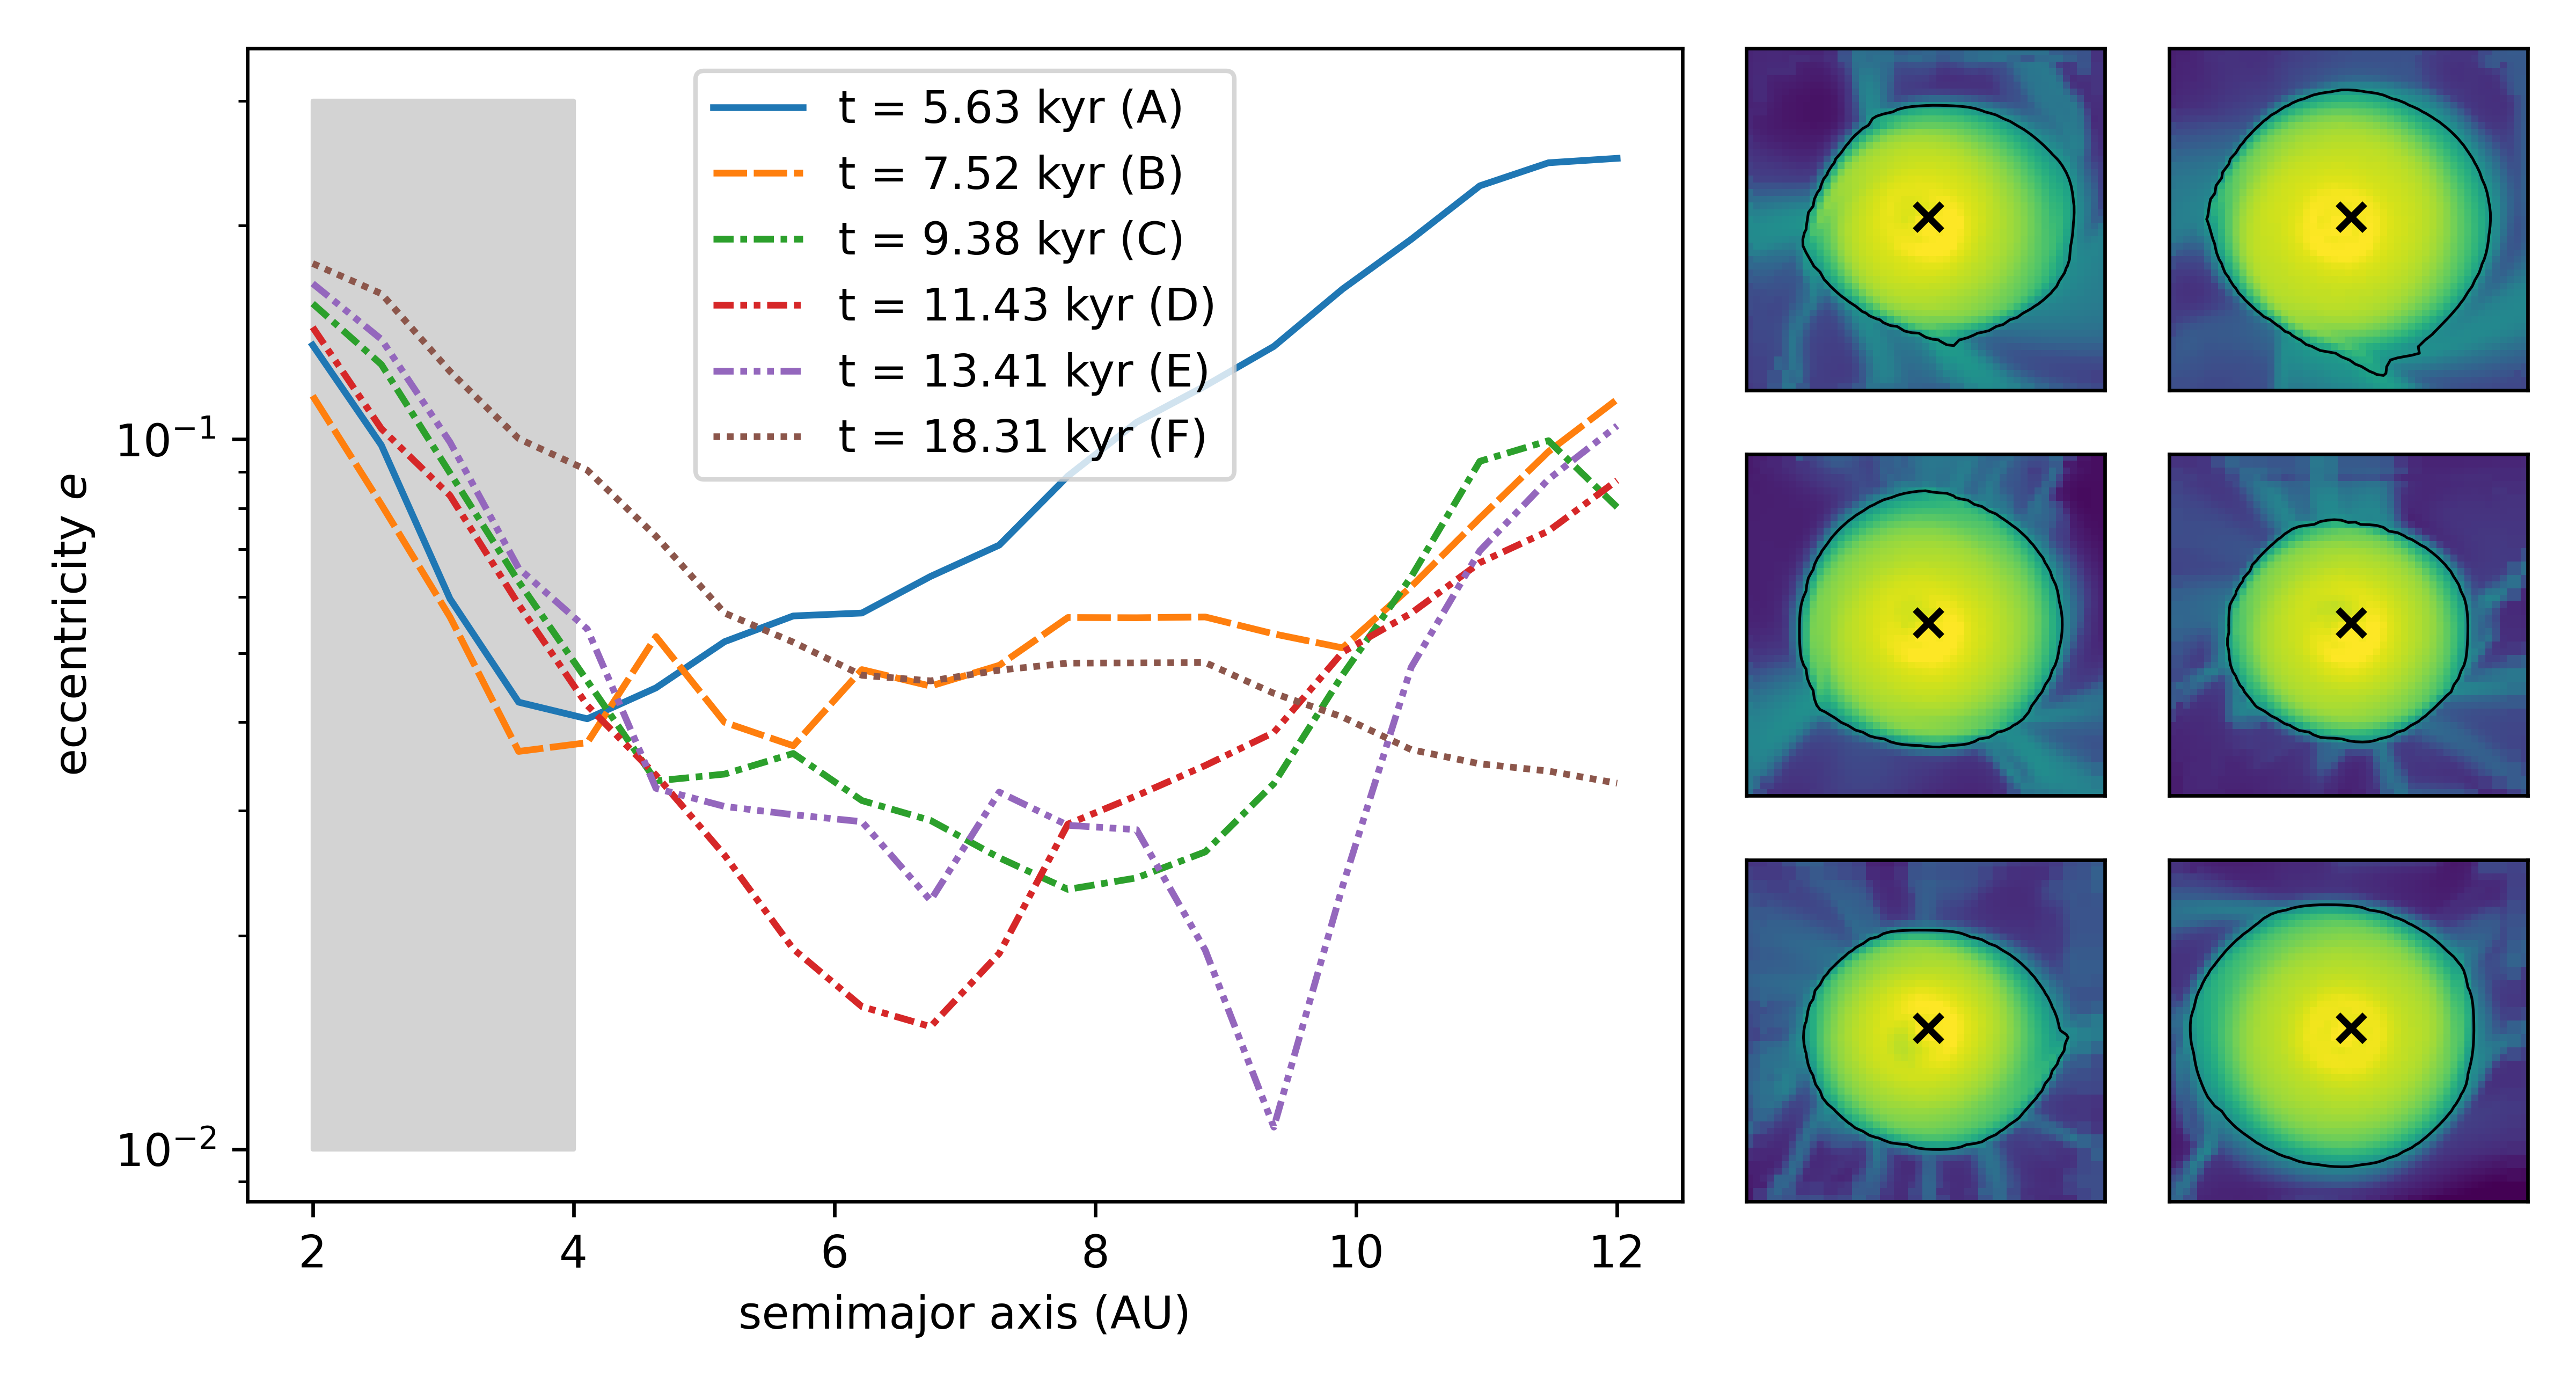

Processing 128 files in ./output_00600
 10% : read     124264 cells,        223 particles
 20% : read     261587 cells,        650 particles
 30% : read     417446 cells,        916 particles
 40% : read     595647 cells,       1075 particles
 50% : read     738268 cells,       1332 particles
 60% : read     876001 cells,       1548 particles
 70% : read    1008493 cells,       1651 particles
 80% : read    1116956 cells,       2173 particles
 90% : read    1242223 cells,       2344 particles
Loaded: 1334950 cells, 13309 particles.
(61, 61, 61, 3)
building amr level 13
building amr level 14
Processing 128 files in ./output_00800
 10% : read      92983 cells,        395 particles
 20% : read     227451 cells,        714 particles
 30% : read     357522 cells,        978 particles
 40% : read     527718 cells,       1127 particles
 50% : read     635787 cells,       1342 particles
 60% : read     777725 cells,       1465 particles
 70% : read     871374 cells,       1548 particles
 80% :

/var/folders/lr/w2rb22ks5v78l_gp4s5dz17h0000gn/T/ipykernel_16416/1332585260.py:92: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


In [10]:
import math

fig = plt.figure(constrained_layout=True,figsize=(8,4.3))
axs = fig.subplot_mosaic([['Left', 'R11', 'R12'],['Left', 'R21', 'R22'],['Left', 'R31', 'R32']],
                          gridspec_kw={'width_ratios':[2,0.5,0.5]})
convert=disctools.constants.conversions()
axs['Left'].fill_betweenx(y=[0.01,0.3],x1=2,x2=4,color='#d3d3d3')

lines=['solid',(0,(5,1)),(0,(3,1,1,1)),(0,(3,1,1,1,1,1)),(0,(3,1,1,1,1,1,1,1)),(0,(1,1))]
letters=["(A)","(B)","(C)","(D)","(E)","(F)"]

for i,n,lsty,lt in zip([600,800,1000,1200,1400,2085],['R11', 'R12', 'R21', 'R22', 'R31', 'R32'],lines,letters):
    data = osyris.Dataset(i, path=".").load();
    data=osyris.extract_box(data,dx=60*osyris.units("au"), dy=60*osyris.units("au"), dz=60*osyris.units("au"), origin=data["sink"]["position"])
    data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
    imp.reload(disctools.datacube)

    dx=(np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values))
    l=(60*convert.au_to_cm,60*convert.au_to_cm,60*convert.au_to_cm)
    s=(-30*convert.au_to_cm,-30*convert.au_to_cm,-30*convert.au_to_cm)
    cube=disctools.datacube.make_cube(dx,l,s)
    print(cube.shape)

    positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
    imap=disctools.datacube.make_amr_mapping(positionArray,cube,data["amr"]["level"].values)
    density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
    velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
    angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
    totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

    cm_to_au = 6.6845871226706E-14
    cube_au=cube*cm_to_au

    sink_pos=np.array((0.0,0.0,0.0))
    sink_pos.reshape(1,3)
    cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
    cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
    cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
    cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)

    sink_age=math.ceil(data["sink"]["age"].values[0])
    radii=np.linspace(2.0,12,20)
    e_list=[]
    a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cut_cube,cut_velocity,cut_density)*convert.cm_to_au
    for a in radii:
        averaged_densities=np.zeros(16)
        #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
        a_mask=np.where(np.abs(a_grid-a)<1.0,True,False)
        #print(cut_cube[a_mask].shape)
        e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cut_cube[a_mask],cut_velocity[a_mask],cut_density[a_mask])
        #print(e)
        e_list.append(e)
    el=np.array([np.linalg.norm(e) for e in e_list])
    
    clip=5
    peak=np.unravel_index(np.argmax(density),density.shape)
    c = axs[n].pcolormesh(cube_au[clip:-clip,peak[1],clip:-clip,0], cube_au[clip:-clip,peak[1],clip:-clip,2],density[clip:-clip,peak[1],clip:-clip],norm=colors.LogNorm(vmin=1e-16,vmax=1e-11), cmap='viridis')
    #cbar=fig.colorbar(c, ax=map_plot1).set_label("density ($\mathrm{g} \cdot \mathrm{cm}^{-3}$)")
    sink_position_point=axs[n].scatter([0.0],[0.0],color="black")
    #cont = map_plot1.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")

    #map_plot1.set_xlabel("x (AU)")
    #map_plot1.set_ylabel("z (AU)")

    c = axs[n].pcolormesh(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], density[clip:-clip,clip:-clip,peak[2]],norm=colors.LogNorm(vmin=1e-16,vmax=1e-11), cmap='viridis')
    #cbar=fig.colorbar(c, ax=axs[n]).set_label("density ($\mathrm{g} \cdot \mathrm{cm}^{-3}$)")
    sink_position_point=axs[n].scatter([0.0],[0.0],color="black",marker='x')
    d = axs[n].contour(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1],np.linalg.norm(angularMom[clip:-clip,clip:-clip,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[clip:-clip,clip:-clip,peak[2],:])), [0.0005],linewidths=[0.6],cmap="magma")
    #cont = map_plot2.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

    #axs[n].set_xlabel("x (AU)")
    #axs[n].yaxis.set_tick_params(labelleft=False,labelbottom=False)
    axs[n].set_yticks([])
    axs[n].set_xticks([])
    #map_plot2.set_ylabel("z (AU)")
    
    
    axs['Left'].plot(radii,el,linestyle=lsty,label=("t = {time:.2f} kyr "+lt).format(time=sink_age/1000))
    
#ecc_plot.plot(radii,el,color='k')
axs['Left'].set_xlabel("semimajor axis (AU)")
axs['Left'].set_ylabel("eccentricity |$\mathbf{e}$|")
#ax['Left'].set_xlim([2, 12])
#ax['Left'].set_ylim([0.01, 0.2])    
    

axs['Left'].set_xlabel("semimajor axis (AU)")
axs['Left'].set_ylabel("eccentricity $e$")
#axs['Left'].set_ylim()
axs['Left'].set_yscale("log")
axs['Left'].legend()
plt.tight_layout()

In [50]:
data = osyris.Dataset(1616, path=".").load()
data=osyris.extract_box(data,dx=60*osyris.units("au"), dy=60*osyris.units("au"), dz=60*osyris.units("au"), origin=data["sink"]["position"])
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
imp.reload(disctools.datacube)

dx=(np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values))
l=(60*convert.au_to_cm,60*convert.au_to_cm,60*convert.au_to_cm)
s=(-30*convert.au_to_cm,-30*convert.au_to_cm,-30*convert.au_to_cm)
cube=disctools.datacube.make_cube(dx,l,s)
print(cube.shape)

positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_amr_mapping(positionArray,cube,data["amr"]["level"].values)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)

radii=np.linspace(1.0,12,60)
e_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)
for a in radii:
    averaged_densities=np.zeros(16)
    #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cube[a_mask],velocity[a_mask],density[a_mask])
    e_list.append(e)
el=np.array([np.linalg.norm(e) for e in e_list])


Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.
(246, 246, 246, 3)
building amr level 13
building amr level 14
building amr level 15
building amr level 16


In [14]:
data = osyris.Dataset(1616, path=".").load()
box_l_x,box_l_y,box_l_z=60,60,60
data=osyris.extract_box(data,dx=box_l_x*osyris.units("au"), dy=box_l_y*osyris.units("au"), dz=box_l_z*osyris.units("au"), origin=data["sink"]["position"])
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
imp.reload(disctools.datacube)

dx=(np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values))
l=(box_l_x*convert.au_to_cm,box_l_y*convert.au_to_cm,box_l_z*convert.au_to_cm)
s=(-0.5*box_l_x*convert.au_to_cm,-0.5*box_l_y*convert.au_to_cm,-0.5*box_l_z*convert.au_to_cm)
cube=disctools.datacube.make_cube(dx,l,s)
print(cube.shape)

positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_amr_mapping(positionArray,cube,data["amr"]["level"].values)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


radii=np.linspace(2.0,12,60)
e_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cut_cube,cut_velocity,cut_density)*convert.cm_to_au
for a in radii:
    averaged_densities=np.zeros(16)
    #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
    a_mask=np.where(np.abs(a_grid-a)<0.3,True,False)
    #print(cut_cube[a_mask].shape)
    e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cut_cube[a_mask],cut_velocity[a_mask],cut_density[a_mask])
    #print(e)
    e_list.append(e)
el=np.array([np.linalg.norm(e) for e in e_list])

Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.
(246, 246, 246, 3)
building amr level 13
building amr level 14
building amr level 15
building amr level 16


<IPython.core.display.Javascript object>


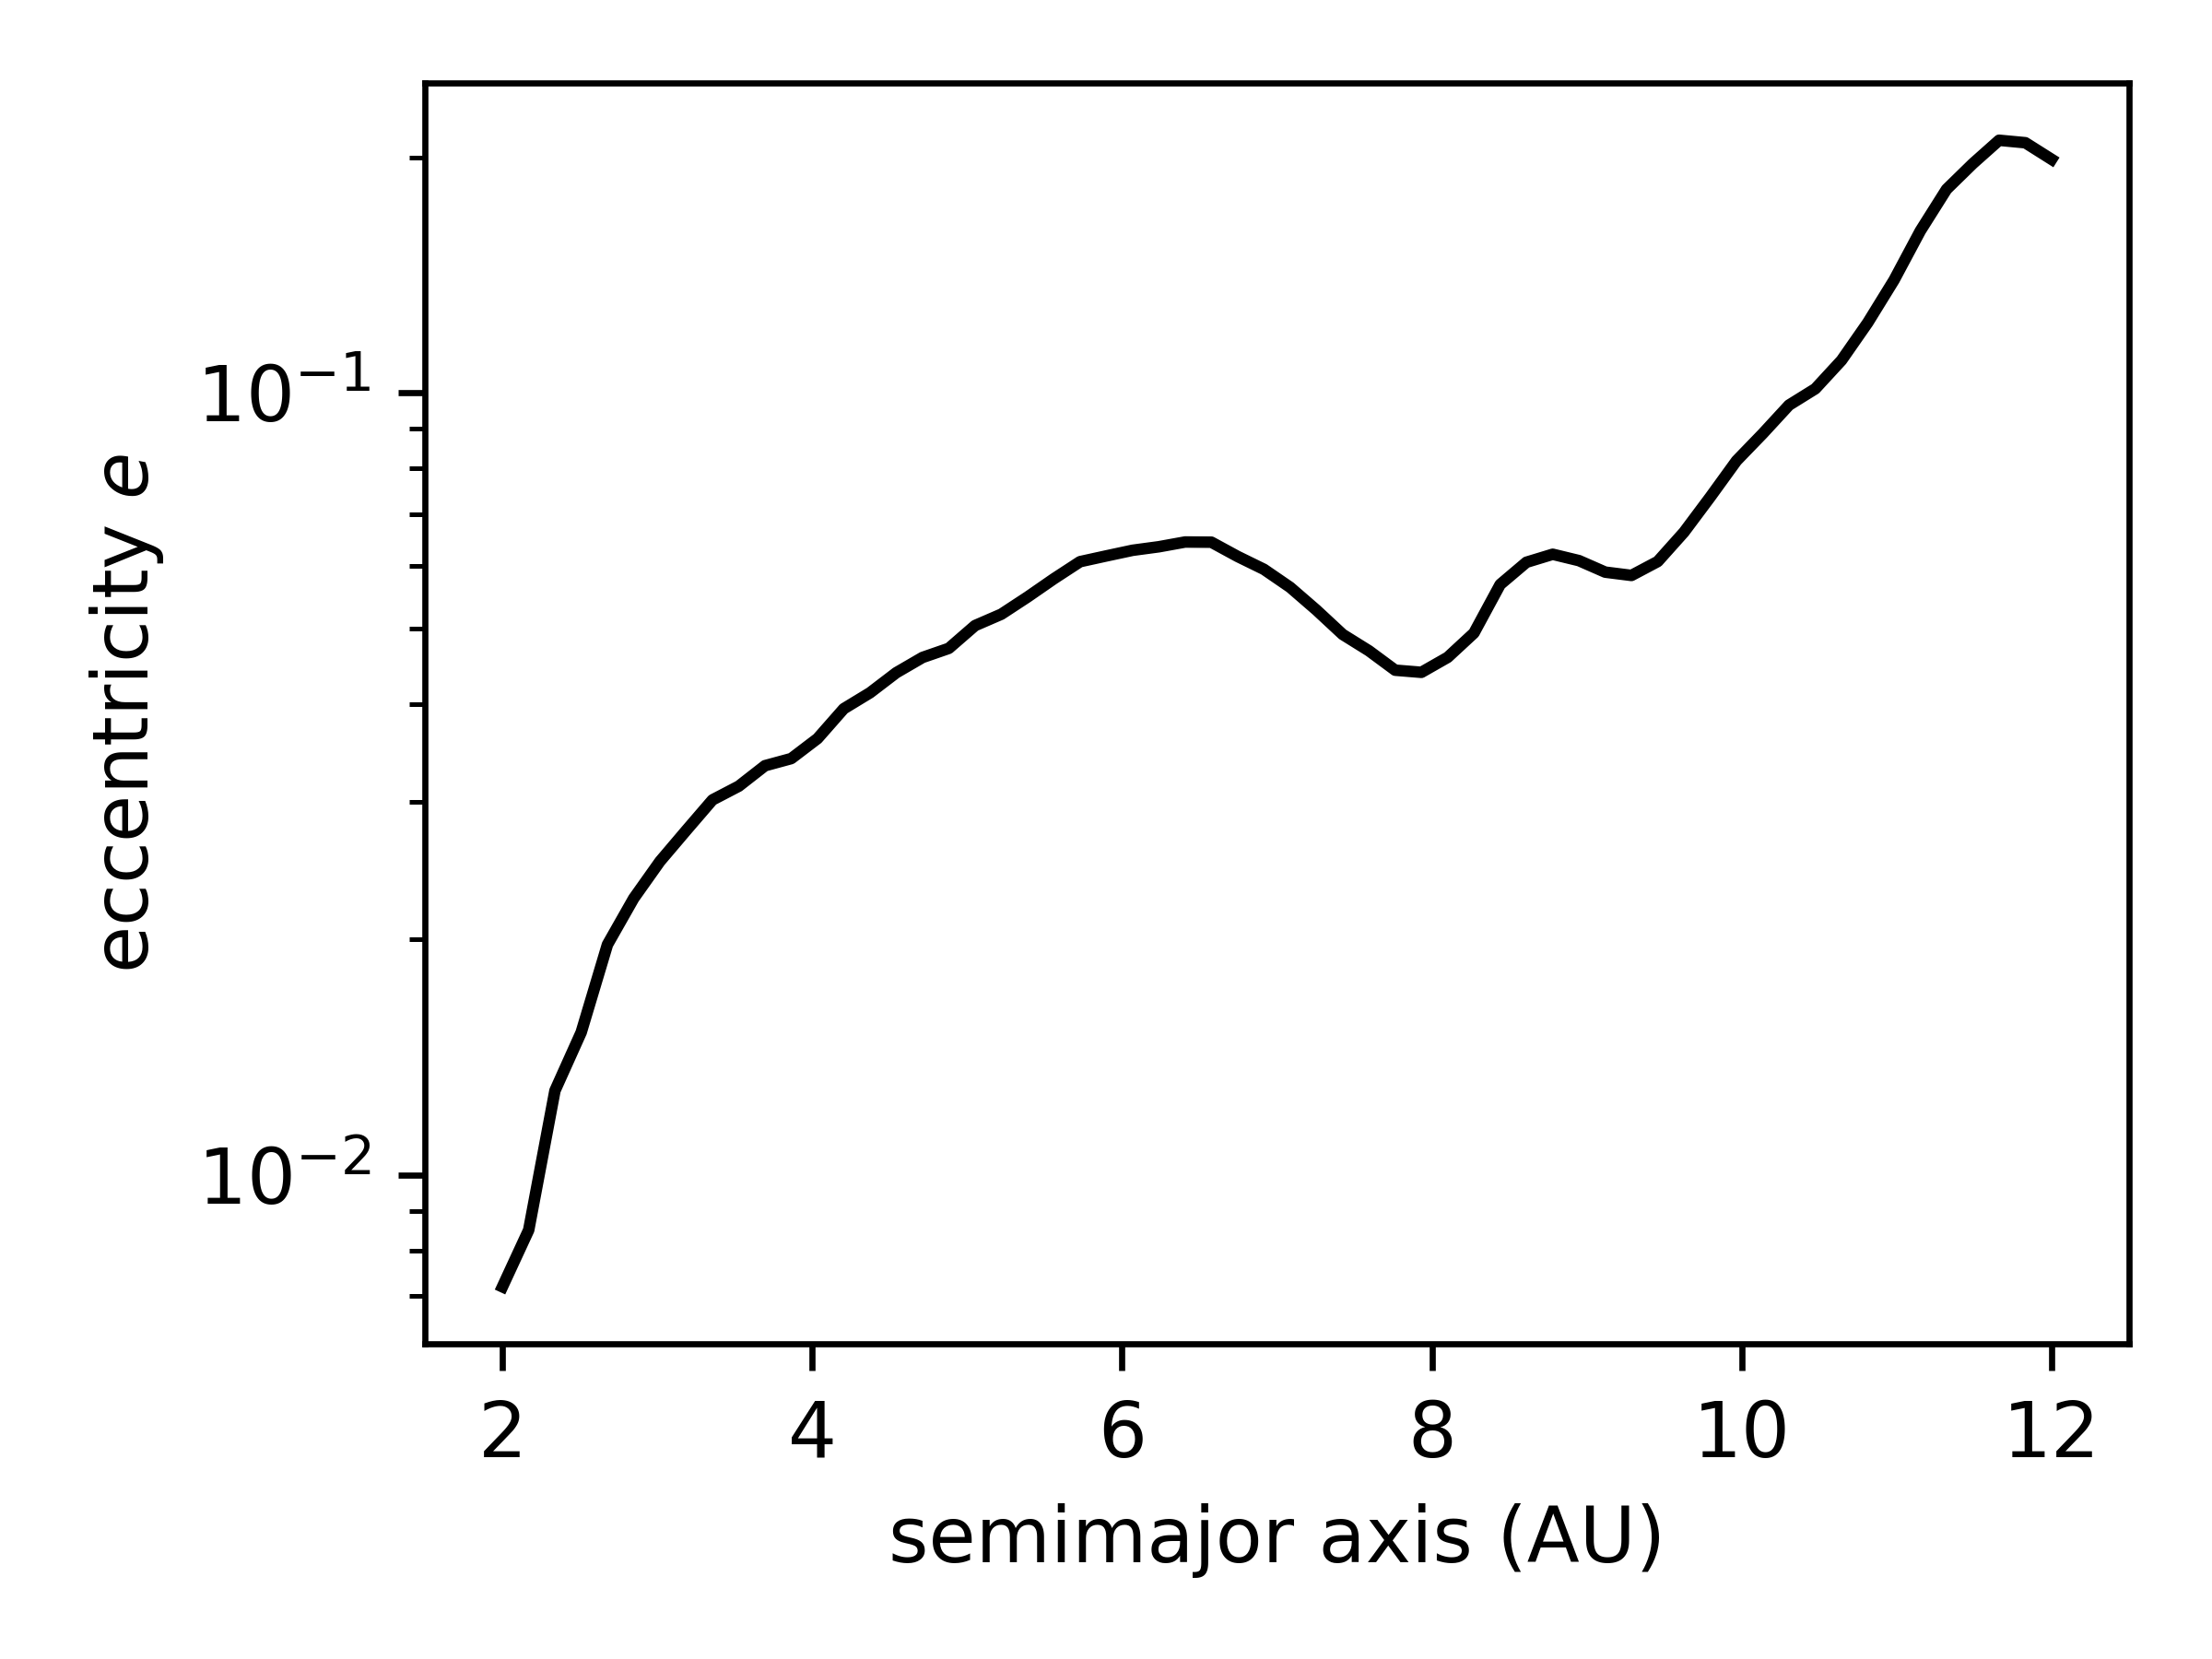

In [15]:
fig, (ecc_plot) = plt.subplots(figsize=(4.0,3))

ecc_plot.plot(radii,el,color='k')
ecc_plot.set_yscale("log")
ecc_plot.set_xlabel("semimajor axis (AU)")
ecc_plot.set_ylabel("eccentricity $e$")

plt.tight_layout()

```python
data = osyris.Dataset(1616, path=".").load()
data=osyris.extract_box(data,dx=40*osyris.units("au"), dy=40*osyris.units("au"), dz=40*osyris.units("au"), origin=data["sink"]["position"]);
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"];

imp.reload(disctools.datacube);
cube=disctools.datacube.osyris_make_cube(data);
cube_au=cube*cm_to_au
positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_mapping(positionArray,data["amr"]["level"].values,cube)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

sink_pos=np.array((0.0,0.0,0.0))
sink_age=math.ceil(data["sink"]["age"].values[0])
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
peak=np.unravel_index(np.argmax(density),density.shape)
radii=np.linspace(1.0,12,30)
e_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)
for a in radii:
    averaged_densities=np.zeros(16)
    #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cube[a_mask],velocity[a_mask],density[a_mask])
    e_list.append(e)
el=np.array([np.linalg.norm(e) for e in e_list])
ecc_plot.plot(radii,el,label="t = "+str(sink_age)+"yr")

```

<IPython.core.display.Javascript object>


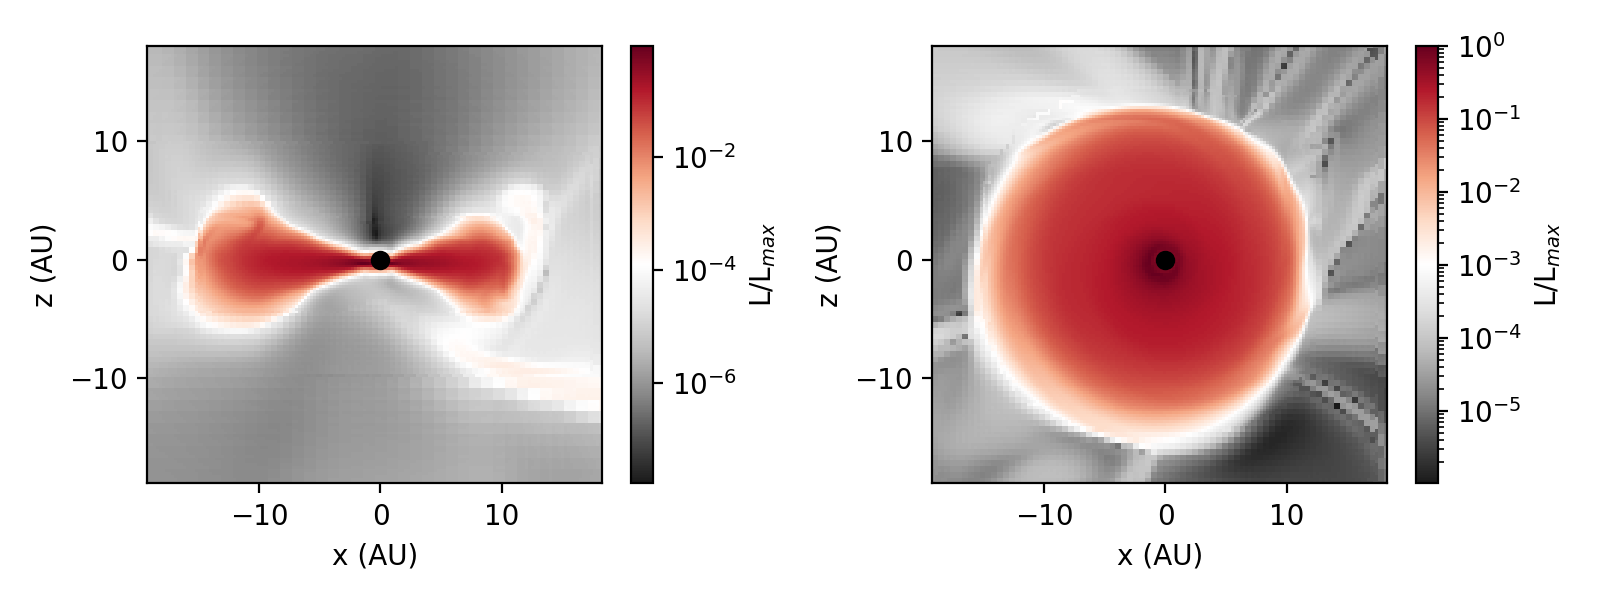

In [11]:
fig, (map_plot1,map_plot2) = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = map_plot1.pcolormesh(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=map_plot1).set_label("L/L$_{max}$")
sink_position_point=map_plot1.scatter([0.0],[0.0],color="black")
#cont = map_plot1.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")

map_plot1.set_xlabel("x (AU)")
map_plot1.set_ylabel("z (AU)")

c = map_plot2.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=map_plot2).set_label("L/L$_{max}$")
sink_position_point=map_plot2.scatter([0.0],[0.0],color="black")
#cont = map_plot2.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot2.set_xlabel("x (AU)")
map_plot2.set_ylabel("z (AU)")

plt.tight_layout()

<IPython.core.display.Javascript object>


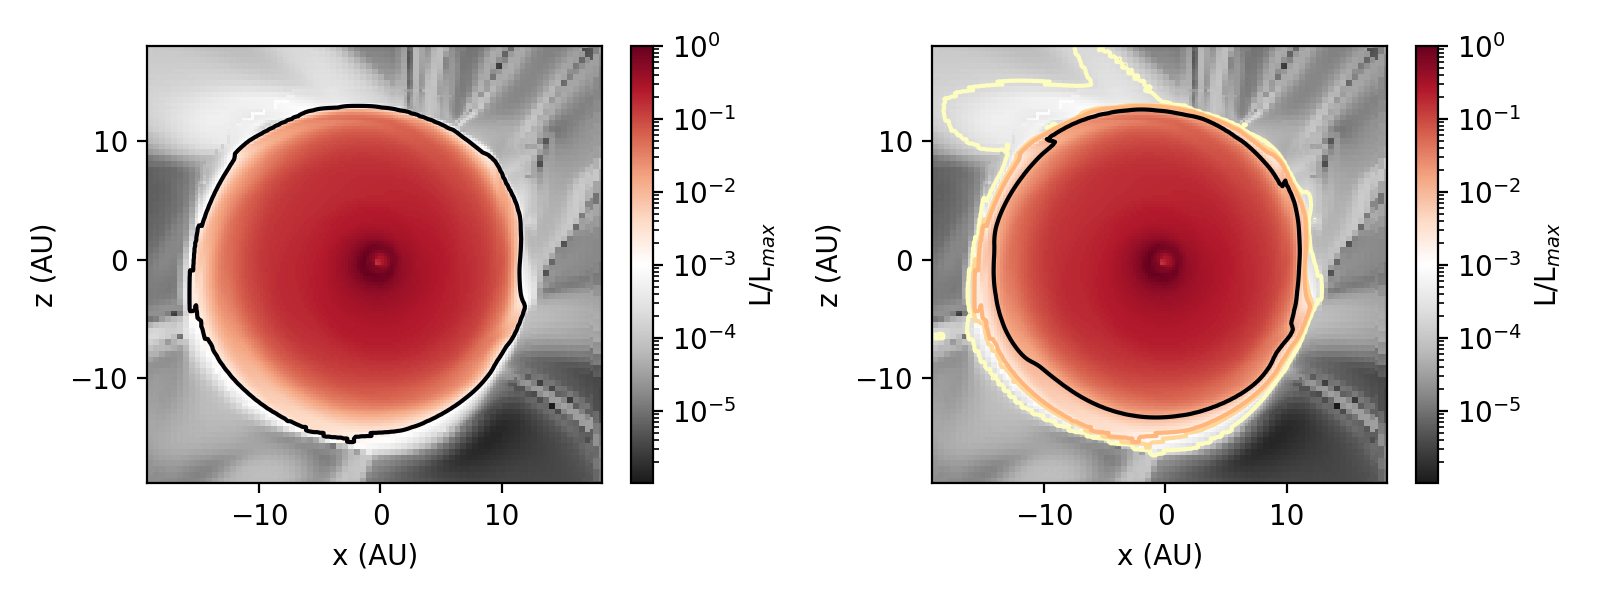

In [12]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

c = ax1.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax1).set_label("L/L$_{max}$")
cont = ax1.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.00001,0.00006,0.0001,0.0006],cmap="magma_r")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax1.set_xlabel("x (AU)")
ax1.set_ylabel("z (AU)")
plt.tight_layout()

In [13]:
@njit
def get_rad_v(velocity,position):
    nx,ny,nz,_=position.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=-velocity[i,j,k,:]@position[i,j,k,:]/np.linalg.norm(position[i,j,k,:])
    return rv

@njit
def get_e_loc(L,a):
    nx,ny,nz,_=L.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=np.sqrt(1.0-L[i,j,k]@L[i,j,k]/(0.264*1.989E33*a[i,j,k]))
    return rv

#ee=get_e_loc(angularMom,a_grid)

In [14]:
radii=np.linspace(1.0,12,100)
rv_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)
for a in radii:
    averaged_densities=np.zeros(16)
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    rv=np.sum([-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(velocity[a_mask],density[a_mask],cube[a_mask])])
    rv_list.append(rv*5.0)

In [15]:
radii_midplane=np.linspace(1.0,12,100)
rv_list_midplane=[]
v_midplane=velocity[:,:,82,:]
x_midplane=cube_au[:,:,82,:]
dens_midplane=density[:,:,82]
a_grid=get_a_on_grid_2D(0.264*1.989E33,x_midplane,v_midplane,dens_midplane)

for a in radii:
    averaged_densities=np.zeros(16)
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    rv=np.sum([-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(v_midplane[a_mask],dens_midplane[a_mask],x_midplane[a_mask])])
    rv_list_midplane.append(rv*5.0)

<IPython.core.display.Javascript object>


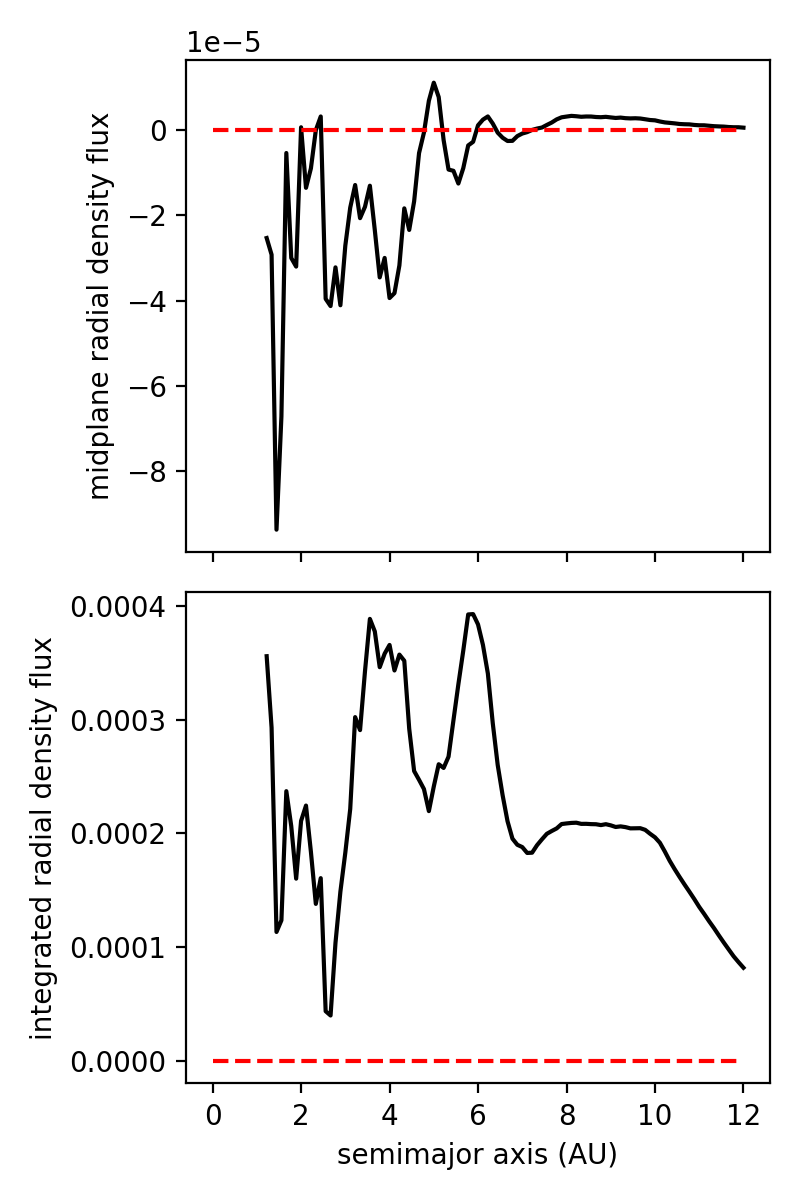

In [16]:
fig, ((midplane,integrated)) = plt.subplots(2,1,figsize=(4,6),gridspec_kw={'height_ratios': [1, 1]},sharex=True)
integrated.plot(radii[2:],rv_list[2:],color='k')
integrated.set_xlabel("semimajor axis (AU)")
integrated.set_ylabel("integrated radial density flux")
integrated.hlines(0,xmin=0,xmax=radii[-1],linestyle="dashed", color="red")
integrated.ticklabel_format(style="sci")

midplane.plot(radii_midplane[2:],rv_list_midplane[2:],color='k')
#midplane.set_xlabel("semimajor axis (AU)")
midplane.hlines(0,xmin=0,xmax=radii[-1],linestyle="dashed", color="red")
midplane.set_ylabel("midplane radial density flux")
plt.tight_layout()

<IPython.core.display.Javascript object>


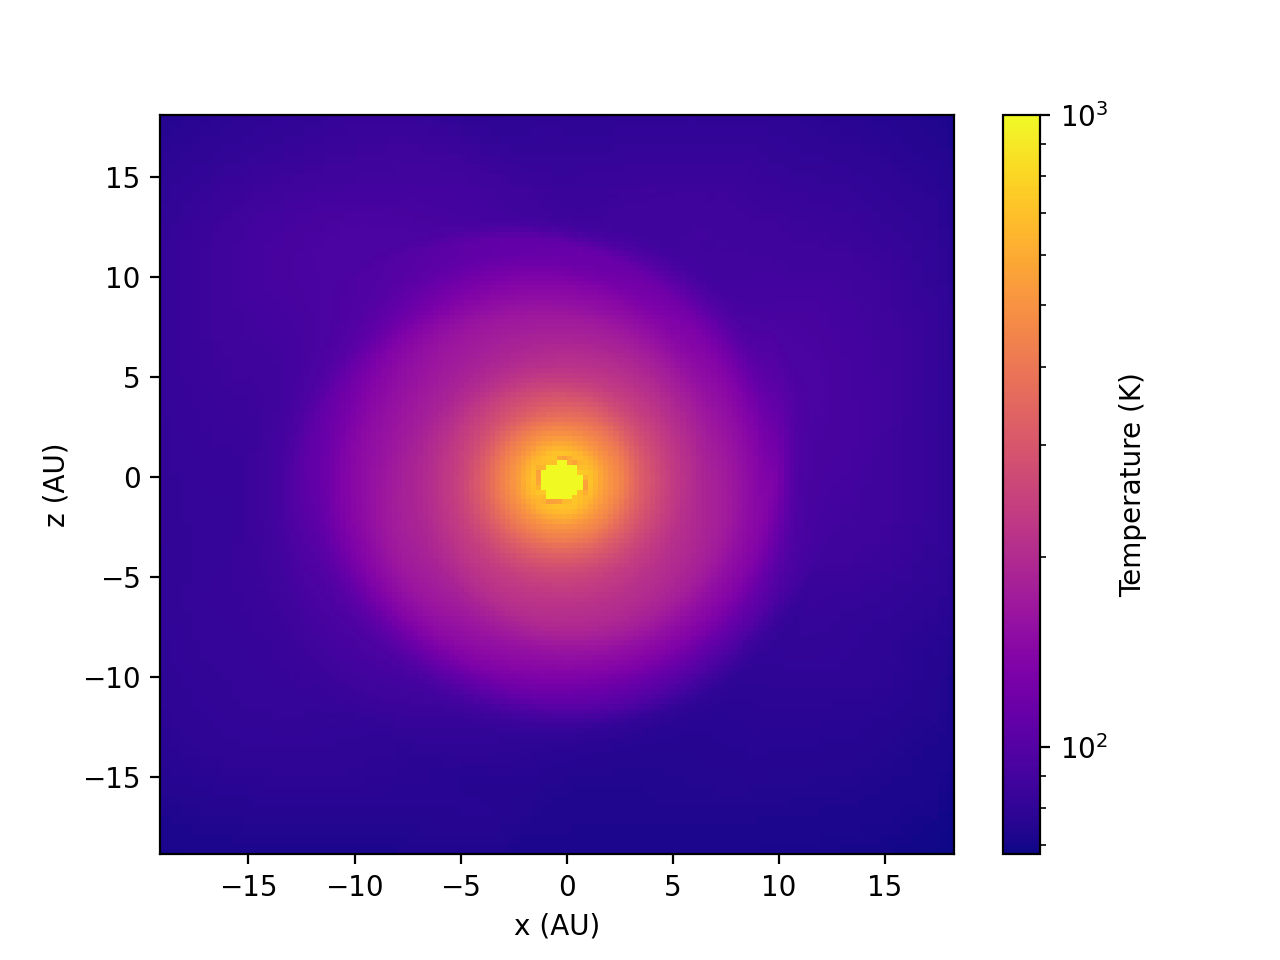

Text(0, 0.5, 'z (AU)')

In [17]:
temperature=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], temperature[5:-5,5:-5,81],norm=colors.LogNorm(vmax=1000),cmap='plasma')
cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


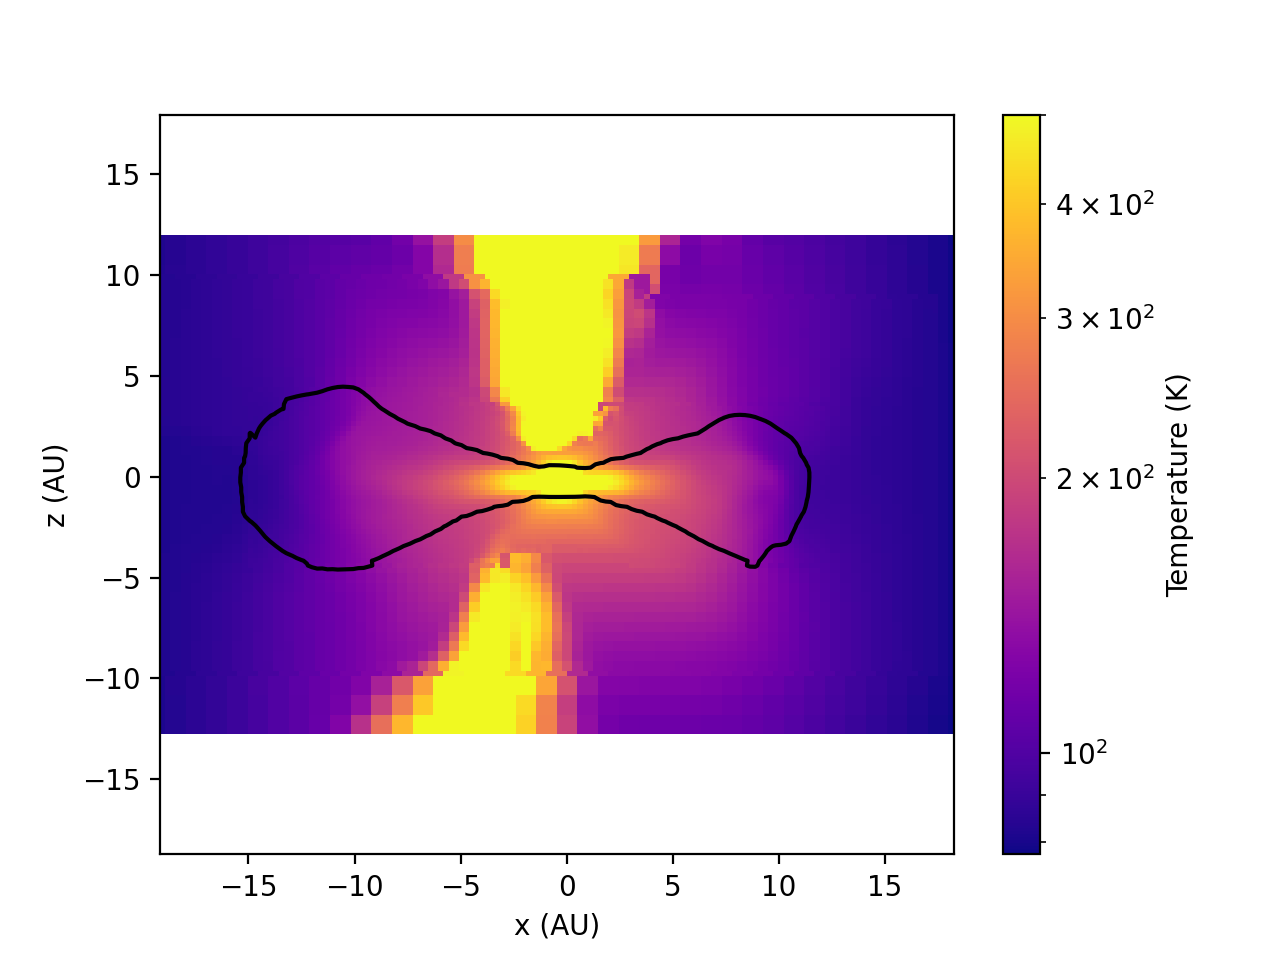

Text(0, 0.5, 'z (AU)')

In [19]:
temperature=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,81,30:-30,0], cube_au[5:-5,81,30:-30,2], temperature[5:-5,81,30:-30],norm=colors.LogNorm(vmax=500), cmap='plasma')
cont = ax.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")
cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


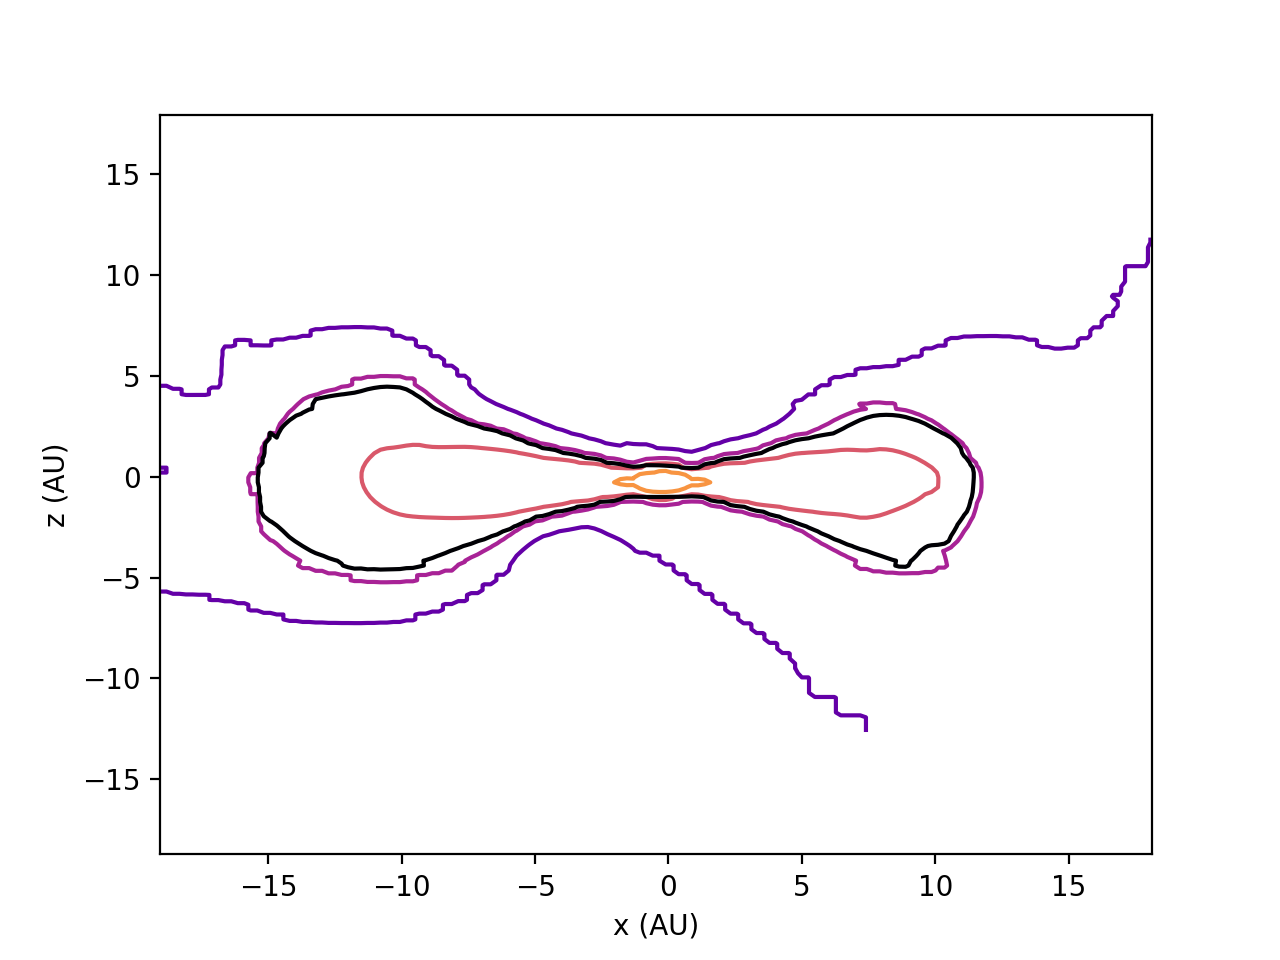

Text(0, 0.5, 'z (AU)')

In [21]:
pressure=disctools.datacube.fill_array_scalar(data["hydro"]["thermal_pressure"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.contour(cube_au[5:-5,81,30:-30,0], cube_au[5:-5,81,30:-30,2], pressure[5:-5,81,30:-30],norm=colors.LogNorm(vmax=500), cmap='plasma')
cont = ax.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")
#cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")